# **CS 1810 Homework 2**
---
To account for potential version issues, try the following in your terminal:

1. Create a new environment with `python3 -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever you use to run your code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

Note that this is not necessary but can help prevent any issues due to package versions.

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn
from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

In [32]:
### Data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

### Data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Automatically Rejected": 0,
    "Require Guarantor": 1,
    "Automatically Accepted": 2
}
data['Type'] = data['Type'].map(mapper)
X_applicants = data[['Debt to Income Ratio', 'Credit Score']].values

# transformation as described in problem statement
def transform(X):
  X = np.stack((X[:,0]*20/0.7-7.5, X[:,1]/140 - (500/140+0.5)), axis=1)
  return X
# Transformation
X_applicants = transform(X_applicants)
y_applicants = data['Type'].values

# Problem 1

## Problem 1 Subpart 1

In [33]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    
    return np.stack([np.ones(len(t)), t, t**2], axis=1)

    pass

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    return np.stack([np.ones(len(t)), t, t**2, t**3, t**4, t**5], axis=1)
    pass


In [34]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1)
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        n = x.shape[0]
        for _ in range(self.runs):
            # linear combination
            z = np.dot(x, self.W)
            # sigmoid function to get probabilities
            p = 1 / (1 + np.exp(-z))
            # gradient (averaged over n data points)
            grad = np.dot(x.T, (p - y)) / n
            self.W = self.W - self.eta * grad

    def predict(self, x):
        """
        Predict classification probability of transformed input x

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        z = np.dot(x, self.W)
        p = 1 / (1 + np.exp(-z))
        return p

In [35]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

1.3706113594753706
Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Fail


/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_61201/1056921069.py:23: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-z))


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [36]:
import os
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    output_dir = 'img_output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    plt.savefig('img_output/' + title + '.png')
    plt.show()

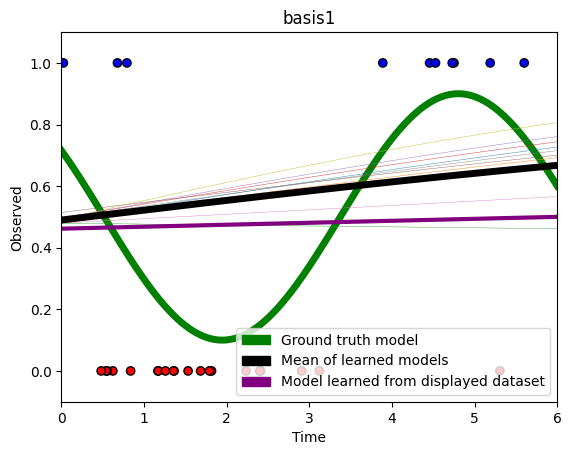

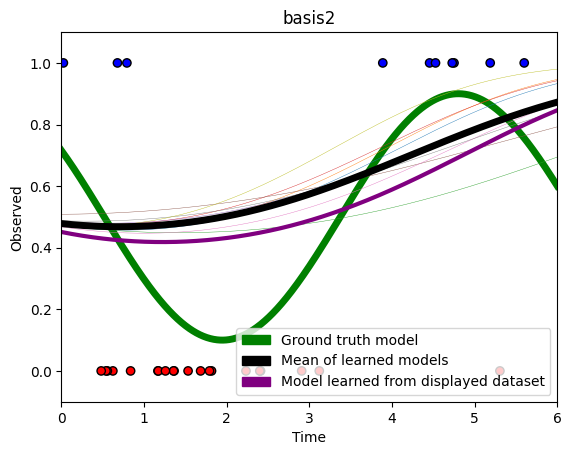

Classification probabilities for t = 0.1: 0.49897088321061844, t = 3.2: 9.358501642951744e-06
Model variances for t = 0.1: 0.00027756844688725014, t = 3.2: 0.15752515480894905


/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_61201/1056921069.py:23: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-z))


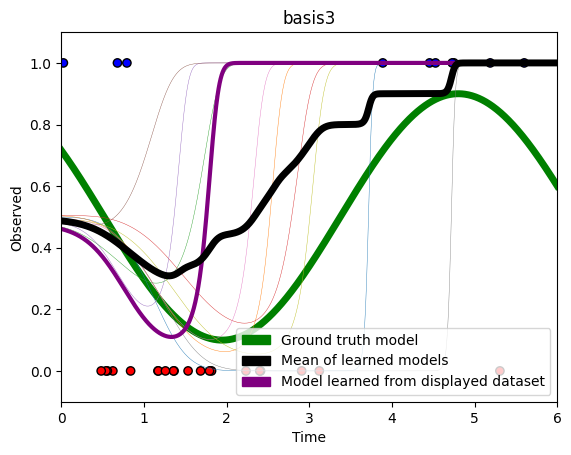

In [37]:
def plot_results(basis, title):
    eta = 0.001
    runs = 1000

    # For Problem 1.4
    test_points_1 = []
    test_points_2 = []
    t1 = basis(np.array([0.1]))
    t2 = basis(np.array([3.2]))

    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

        if basis == basis3:
            # extract values from (1 x 1) array
            pred_1 = model.predict(t1)[0, 0]
            pred_2 = model.predict(t2)[0, 0]
            if i == 0:
                print(f"Classification probabilities for t = 0.1: {pred_1}, t = 3.2: {pred_2}")
            test_points_1.append(pred_1)
            test_points_2.append(pred_2)

    if basis == basis3:
        print(f"Model variances for t = 0.1: {np.var(test_points_1)}, t = 3.2: {np.var(test_points_2)}")
    visualize_prediction_lines(x, y, all_models, basis, title)

plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

# Problem 3

In [38]:
from scipy.stats import multivariate_normal



class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance
        self.classes = None
        self.mu = {}         # Stores the class means (using \vec{\mu})
        self.priors = {}     # Stores the class priors (using \vec{\pi})
        self.cov = {}        # Stores individual covariance matrices (for each \vec{\Sigma}_k)
        self.shared_cov = None  # Shared covariance matrix (if applicable)

    def fit(self, X, y):
        """
        Compute the means and (shared) covariance matrix of the data. Compute the prior over y.

        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
        :return: None
        """
        n, d = X.shape
        self.classes = np.unique(y)
        for k in self.classes:
            X_k = X[y == k]
            n_k = X_k.shape[0]
            self.priors[k] = n_k / n
            self.mu[k] = np.mean(X_k, axis=0)
        if self.is_shared_covariance:
            cov_matrix = np.zeros((d, d))
            for k in self.classes:
                X_k = X[y == k]
                diff = X_k - self.mu[k]
                cov_matrix += diff.T @ diff
            self.shared_cov = cov_matrix / n
        else:
            for k in self.classes:
                X_k = X[y == k]
                n_k = X_k.shape[0]
                diff = X_k - self.mu[k]
                self.cov[k] = (diff.T @ diff) / n_k

    def predict_proba(self, X_pred):
        """
        Predict classification probabilities of points given feature values in X_pred.
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities.
                 Shape should be (n x number_of_classes)
        """
        n = X_pred.shape[0]
        probs = np.zeros((n, len(self.classes)))
        for idx, k in enumerate(self.classes):
            if self.is_shared_covariance:
                cov = self.shared_cov
            else:
                cov = self.cov[k]
            try:
                rv = multivariate_normal(mean=self.mu[k], cov=cov, allow_singular=True)
                likelihood = rv.pdf(X_pred)
            except np.linalg.LinAlgError:
                cov += np.eye(cov.shape[0]) * 1e-6
                rv = multivariate_normal(mean=self.mu[k], cov=cov, allow_singular=True)
                likelihood = rv.pdf(X_pred)
            probs[:, idx] = self.priors[k] * likelihood
        probs_sum = np.sum(probs, axis=1, keepdims=True)
        probs_normalized = probs / (probs_sum + 1e-12)
        return probs_normalized

    def predict(self, X_pred):
        """
        Predict classes of points given feature values in X_pred

        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        probs = self.predict_proba(X_pred)
        pred_indices = np.argmax(probs, axis=1)
        pred_labels = np.array([self.classes[idx] for idx in pred_indices])
        return pred_labels

    def negative_log_likelihood(self, X, y):
        """
        Given the data X, use previously calculated class means and covariance matrix to
        calculate the negative log likelihood of the data
        """
        n = X.shape[0]
        nll = 0.0
        for i in range(n):
            k = y[i]
            x_i = X[i]
            if self.is_shared_covariance:
                cov = self.shared_cov
            else:
                cov = self.cov[k]
            try:
                rv = multivariate_normal(mean=self.mu[k], cov=cov, allow_singular=True)
                likelihood = rv.pdf(x_i)
            except np.linalg.LinAlgError:
                cov += np.eye(cov.shape[0]) * 1e-6
                rv = multivariate_normal(mean=self.mu[k], cov=cov, allow_singular=True)
                likelihood = rv.pdf(x_i)
            prob = self.priors[k] * likelihood
            nll -= np.log(prob + 1e-12)
        return nll


In [39]:
import numpy as np

class SoftmaxRegression:
    def __init__(self, eta, lam, verbose=True):
        self.eta = eta
        self.lam = lam
        self.W = None
        self.verbose = verbose

    def _one_hot(self, y, num_classes):
        """
        Convert labels to one-hot encoding.
        """
        n = len(y)
        one_hot = np.zeros((n, num_classes))
        for i, label in enumerate(y):
            one_hot[i, label] = 1
        return one_hot

    def _softmax(self, Z):
        """
        Compute softmax values for each set of scores in Z.
        """
        Z_stable = Z - np.max(Z, axis=1, keepdims=True)
        exp_Z = np.exp(Z_stable)
        softmax_scores = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
        return softmax_scores

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
        :return: None
        """
        n, d = X.shape
        num_classes = len(np.unique(y))
        # Add bias term to X
        X_bias = np.hstack((np.ones((n, 1)), X))
        # Initialize weights W (including bias) as zeros
        self.W = np.zeros((d + 1, num_classes))
        # One-hot encode y
        Y_one_hot = self._one_hot(y, num_classes)
        
        max_iter = 200000
        for it in range(max_iter):
            scores = X_bias @ self.W  # shape (n x num_classes)
            probs = self._softmax(scores)
            grad = X_bias.T @ (probs - Y_one_hot) + self.lam * self.W
            self.W -= self.eta * grad
            if self.verbose and it % 10000 == 0:
                loss = -np.sum(Y_one_hot * np.log(probs + 1e-12)) + 0.5 * self.lam * np.sum(self.W * self.W)
                print(f"Iteration {it}: loss = {loss}")
            # Check for convergence
            if np.linalg.norm(grad) < 1e-6:
                if self.verbose:
                    print(f"Converged at iteration {it}")
                break

    def predict(self, X_pred):
        """
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        n = X_pred.shape[0]
        X_bias = np.hstack((np.ones((n, 1)), X_pred))
        scores = X_bias @ self.W
        probs = self._softmax(scores)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Automatically Rejected=index 0, Require Guarantor=index 1, Automatically Accepted=index 2).
                 Shape should be (n x 3)
        """
        n = X_pred.shape[0]
        X_bias = np.hstack((np.ones((n, 1)), X_pred))
        scores = X_bias @ self.W
        probs = self._softmax(scores)
        return probs


In [40]:
from collections import Counter

class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k

    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y

    def predict(self, X_pred_many):
        """
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Automatically Rejected=0, Require Guarantor=1, Automatically Accepted=2).
                 Shape should be (n,)
        """
        predictions = []
        for x in X_pred_many:
            diffs = self.X - x 
            distances = (diffs[:, 0]**2) / 9 + diffs[:, 1]**2
            k_indices = np.argsort(distances)[:self.K]
            k_labels = self.y[k_indices]
            count = Counter(k_labels)
            pred_label = min(count.keys(), key=lambda key: (-count[key], key))
            predictions.append(pred_label)
        return np.array(predictions)


In [41]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    transformed = np.column_stack((np.log(X[:, 0] + 10), X[:, 1]**2))
    return transformed

def transform(X):
    """
    Transform [x_1, x_2] using the primary transformation:
    [x_1 * (200/7) - 7.5, (x_2 - 500)/140 + 0.5]

    :param X: a 2D numpy array of original feature values. Shape is (n x 2)
    :return: a 2D numpy array of transformed features. Shape is (n x 2)
    """
    transformed = np.column_stack((X[:, 0] * 200/7 - 7.5, (X[:, 1] - 500)/140 + 0.5))
    return transformed

## Plotting Function for Problem 3, Subpart 1

In [42]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=10):
    # Create a grid of points
    x_min, x_max = min(X[:, 0]-width*0.15), max(X[:, 0]+width*0.15)
    y_min, y_max = min(X[:, 1]-width*0.2), max(X[:, 1]+width*0.2)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T

    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Debt to Income Ratio')
    plt.ylabel('Credit Score')

    ticks = np.transpose(np.array([[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                                   [300, 400, 500, 600, 700, 800, 900, 1000]]))
    transformed_ticks = transform(ticks)


    plt.xticks(transformed_ticks[:,0],
               ticks[:,0])
    plt.yticks(transformed_ticks[:,1],
               ticks[:,1])
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Automatically Rejected')
    blue = mpatches.Patch(color='blue', label='Require Guarantor')
    green = mpatches.Patch(color='green', label='Automatically Accepted')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig('img_output/' + title + '.png')
    plt.show()

## Problem 3, Subpart 1

Iteration 0: loss = 29.662533703617825
Iteration 10000: loss = 5.088415048066756
Iteration 20000: loss = 3.8036959814398905
Iteration 30000: loss = 3.2307660451746374
Iteration 40000: loss = 2.8940076847053122
Iteration 50000: loss = 2.668430904327212
Iteration 60000: loss = 2.505246393570823
Iteration 70000: loss = 2.3810602856321434
Iteration 80000: loss = 2.2831056980068825
Iteration 90000: loss = 2.2037602345897227
Iteration 100000: loss = 2.1381606909126445
Iteration 110000: loss = 2.083041375342677
Iteration 120000: loss = 2.0361182402022813
Iteration 130000: loss = 1.995739938027298
Iteration 140000: loss = 1.9606792248247387
Iteration 150000: loss = 1.9300026195945885
Iteration 160000: loss = 1.9029858747706312
Iteration 170000: loss = 1.8790573880074557
Iteration 180000: loss = 1.8577592656776625
Iteration 190000: loss = 1.8387198824580646
Iteration 0: loss = 1186.7190226007876
Iteration 10000: loss = 11124.976336024096
Iteration 20000: loss = 40127.33377214692
Iteration 30000

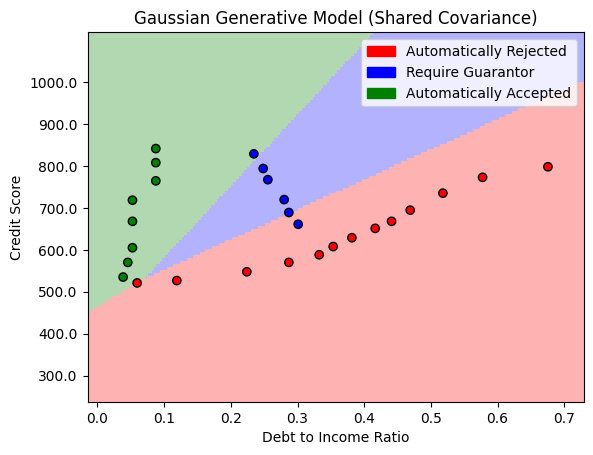

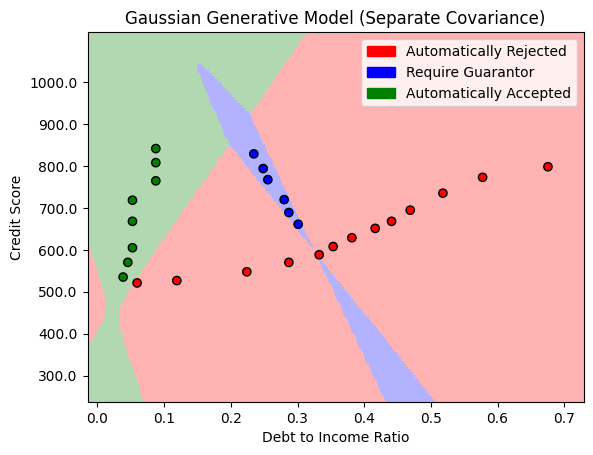

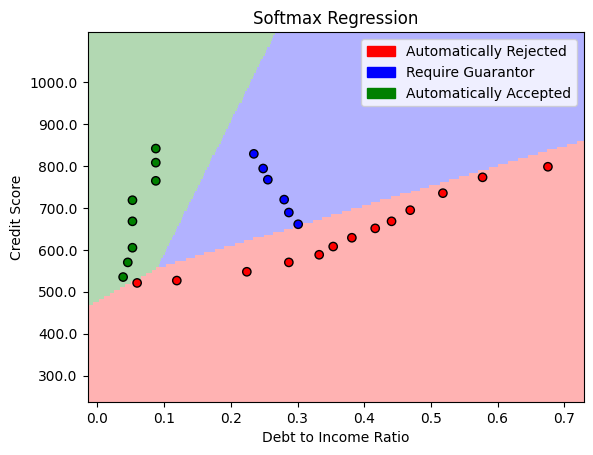

/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_61201/2143858342.py:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('img_output/' + title + '.png')


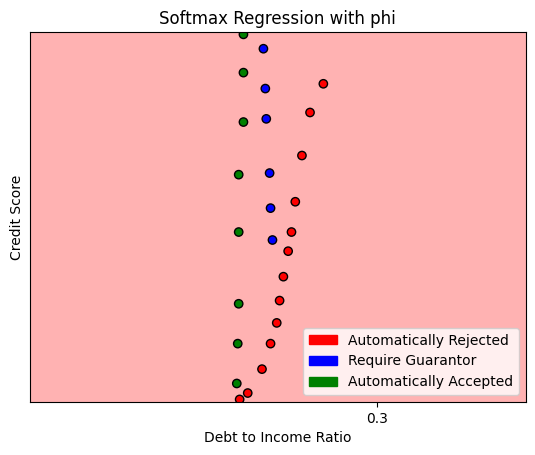

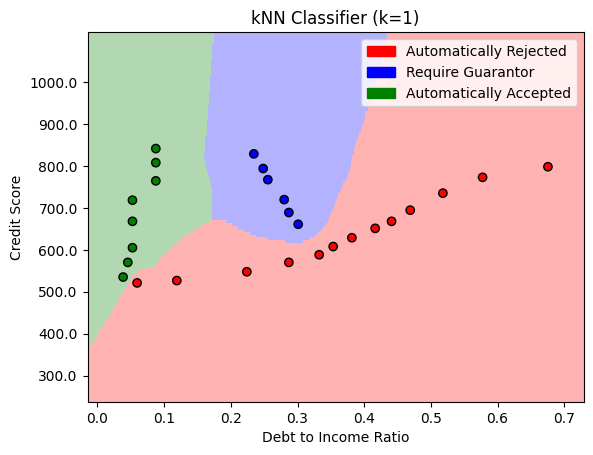

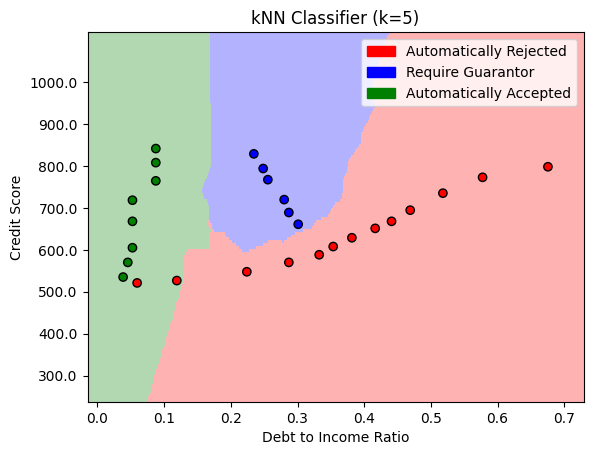

In [43]:
label_mapping = {
    "Automatically Rejected": 0,
    "Require Guarantor": 1,
    "Automatically Accepted": 2
}

X_original = np.loadtxt('data/hr.csv', delimiter=',', skiprows=1, usecols=(1,2))

y_strings = np.loadtxt('data/hr.csv', delimiter=',', skiprows=1, usecols=0, dtype=str)

y = np.array([label_mapping[label.strip()] for label in y_strings])

X = transform(X_original)

ggm_shared = GaussianGenerativeModel(is_shared_covariance=True)
ggm_shared.fit(X, y)

ggm_separate = GaussianGenerativeModel(is_shared_covariance=False)
ggm_separate.fit(X, y)

softmax_model = SoftmaxRegression(eta=0.001, lam=0.001, verbose=True)
softmax_model.fit(X, y)

X_phi = phi(X_original)
softmax_phi_model = SoftmaxRegression(eta=0.001, lam=0.001, verbose=True)
softmax_phi_model.fit(X_phi, y)


knn_1 = KNNClassifier(k=1)
knn_1.fit(X, y)


knn_5 = KNNClassifier(k=5)
knn_5.fit(X, y)


visualize_boundary(ggm_shared, X, y, title="Gaussian Generative Model (Shared Covariance)", basis=None)
visualize_boundary(ggm_separate, X, y, title="Gaussian Generative Model (Separate Covariance)", basis=None)
visualize_boundary(softmax_model, X, y, title="Softmax Regression", basis=None)
visualize_boundary(softmax_phi_model, X_original, y, title="Softmax Regression with phi", basis=phi)
visualize_boundary(knn_1, X, y, title="kNN Classifier (k=1)", basis=None)
visualize_boundary(knn_5, X, y, title="kNN Classifier (k=5)", basis=None)


In [44]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

print("Accuracy:")
print("Gaussian Generative Model (Shared Covariance):", accuracy(y, ggm_shared.predict(X)))
print("Gaussian Generative Model (Separate Covariance):", accuracy(y, ggm_separate.predict(X)))
print("Softmax Regression:", accuracy(y, softmax_model.predict(X)))
print("Softmax Regression with phi:", accuracy(y, softmax_phi_model.predict(phi(X_original))))
print("kNN Classifier (k=1):", accuracy(y, knn_1.predict(X)))
print("kNN Classifier (k=5):", accuracy(y, knn_5.predict(X)))


Accuracy:
Gaussian Generative Model (Shared Covariance): 0.9259259259259259
Gaussian Generative Model (Separate Covariance): 1.0
Softmax Regression: 1.0
Softmax Regression with phi: 0.48148148148148145
kNN Classifier (k=1): 1.0
kNN Classifier (k=5): 0.9259259259259259


## Problem 3, Subpart 2

In [45]:
# Predicting for new applicant
new_applicant_original = np.array([(0.32, 350)])
new_applicant_transformed = transform(new_applicant_original)
new_applicant_phi = phi(new_applicant_original)

print("New applicant transformed (T1):", new_applicant_transformed)
print("New applicant transformed (phi):", new_applicant_phi)

print("Predictions for new applicant:")
print("Gaussian Generative Model (Shared):", ggm_shared.predict(new_applicant_transformed))
print("Gaussian Generative Model (Separate):", ggm_separate.predict(new_applicant_transformed))
print("Softmax Regression Prediction:", softmax_model.predict(new_applicant_transformed))
print("Softmax Regression Prediction with phi:", softmax_phi_model.predict(new_applicant_phi))
print("kNN Classifier (k=1):", knn_1.predict(new_applicant_transformed))
print("kNN Classifier (k=5):", knn_5.predict(new_applicant_transformed))


print("Softmax Regression Probabilities:", softmax_model.predict_proba(new_applicant_transformed))
print("Softmax Regression with phi Probabilities:", softmax_phi_model.predict_proba(new_applicant_phi))



New applicant transformed (T1): [[ 1.64285714 -0.57142857]]
New applicant transformed (phi): [[2.33408376e+00 1.22500000e+05]]
Predictions for new applicant:
Gaussian Generative Model (Shared): [0]
Gaussian Generative Model (Separate): [0]
Softmax Regression Prediction: [0]
Softmax Regression Prediction with phi: [0]
kNN Classifier (k=1): [0]
kNN Classifier (k=5): [0]
Softmax Regression Probabilities: [[1.00000000e+00 9.98941824e-16 6.67083365e-24]]
Softmax Regression with phi Probabilities: [[1. 0. 0.]]
